In [ ]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
import skimage
import matplotlib.pyplot as plt
import keras.backend as K
#from vis.utils import utils
from os import listdir
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
!gdown --id 1-3360B0mciNsg-tLaj482APOR9IPYVUT
!unzip val_1000.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-3360B0mciNsg-tLaj482APOR9IPYVUT
To: /content/val_1000.zip
100% 22.6M/22.6M [00:00<00:00, 79.4MB/s]
Archive:  val_1000.zip
   creating: val_1000/
  inflating: val_1000/cat_705.jpg    
  inflating: val_1000/cat_947.jpg    
  inflating: val_1000/dog_87.jpg     
  inflating: val_1000/dog_186.jpg    
  inflating: val_1000/dog_764.jpg    
  inflating: val_1000/cat_104.jpg    
  inflating: val_1000/cat_429.jpg    
  inflating: val_1000/dog_302.jpg    
  inflating: val_1000/dog_807.jpg    
  inflating: val_1000/cat_616.jpg    
  inflating: val_1000/dog_46.jpg     
  inflating: val_1000/cat_35.jpg     
  inflating: val_1000/cat_647.jpg    
  inflating: val_1000/cat_551.jpg    
  inflating: val_1000/cat_746.jpg    
  inflating: va

In [ ]:
import random
from random import shuffle
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence


In [ ]:
def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files

  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files



In [ ]:
val_imgs = '/content/val_1000'
class_info = {0: 'Cat', 1: 'Dog'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|██████████| 1000/1000 [00:03<00:00, 279.79it/s]


In [ ]:
def img_preprocess(img):

    min_img_range = -1
    max_img_range = 1
    img = skimage.transform.resize(img,(224,224,3), mode='constant', anti_aliasing=False) ## anti_aliasing has to be False
#     img = skimage.transform.resize(img,(299,299,3))
    img = min_img_range + img * (max_img_range-min_img_range)

    return img


def get_cav(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type = 'sgd'):

    X = np.vstack([concept_act_s,random_act_s])
    # X = (X-np.mean(X))/np.std(X)
    y = np.hstack([concept_lbl_s, random_lbl_s])
    X_tr, X_vl, y_tr, y_vl = train_test_split(X, y, shuffle= True)

    print('X train size: ',X_tr.shape)
    print('y train size: ',y_tr.shape)
    print('X valid size: ',X_vl.shape)
    print('y valid size: ',y_vl.shape)

    if clf_type == 'sgd':
        clf = linear_model.SGDClassifier(alpha=.01)

    elif clf_type == 'logistic':
        clf = linear_model.LogisticRegression(max_iter = 1000)

    clf.fit(X_tr, y_tr)


    print('Training score: ',clf.score(X_tr, y_tr))
    print('Validation score: ',clf.score(X_vl, y_vl))

    #cavs = [-1 * clf.coef_[0], clf.coef_[0]]  ## cavs[0]: stripes, cavs[1]: no_stripes
    cavs = -np.array(clf.coef_)
    unit_normal_cav = cavs/np.linalg.norm(cavs)

    return unit_normal_cav



def get_directional_derivative(img, model, layer_name, cav):

    sess = K.get_session()
    grad_out_wrt_layer = K.gradients(model.output, model.get_layer(layer_name).output)[0] # Gradient of output wrt the layer of the model
    grad_sample_activation = sess.run(grad_out_wrt_layer, feed_dict={model.input: np.expand_dims(img,0)})
    directional_derivative = np.dot(np.reshape(grad_sample_activation.flatten(),-1),cav)
    sign_dir_der = directional_derivative < 0

    return sign_dir_der, directional_derivative

In [ ]:
model_inception = InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)



96112376/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                         

In [ ]:
model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
layer_name = activation_layers[20]
try:
  lay_idx = model.layers.index(model.get_layer(layer_name))
except ValueError:
  raise ValueError('Layer not found: {}'.format(layer_name))
get_layer_activation = K.function([model.input], [model.layers[lay_idx].output])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/concepts'
!cp -a {folder_path} /content/drive/MyDrive/

cp: cannot stat '/content/concepts': No such file or directory


(7, 7, 1280)


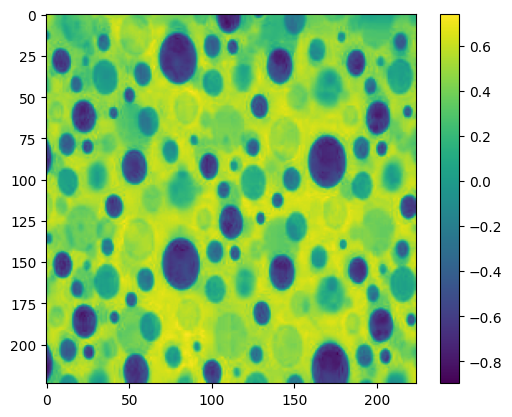

In [ ]:
root_dir = '/content/drive/MyDrive/concepts/dotted'
for file in listdir(root_dir):
  img = skimage.io.imread(root_dir+ '/' + file)
  img = img_preprocess(img)

  plt.imshow(img[:,:,2])
  plt.colorbar()

  activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])
  print(activation.shape)
  break

  #print('Flat activation size: ', activation.flatten().shape[0])


  plt.subplot(1,4,1)
  #plt.title('visualize layer activation')
  plt.imshow(activation[:,:,100])
  plt.subplot(1,4,2)
  plt.imshow(activation[:,:,400])
  plt.subplot(1,4,3)
  plt.imshow(activation[:,:,300])
  plt.subplot(1,4,4)
  plt.imshow(img)
  plt.show()


In [ ]:
tgt_patterns = ['zigzagged']
rnd_patterns = ['random500_0']
path = '/content/drive/MyDrive/concepts/{}'


### concept set

concept_act_s = []
concept_lbl_s = []


for patt in tgt_patterns:
  folder_path = path.format(patt)
  for file in listdir(folder_path):
    img_path = folder_path+ '/' +file
    img = skimage.io.imread(img_path)
    img = img_preprocess(img)
    activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])

    concept_act_s.append(activation.flatten())
    concept_lbl_s.append(0)

In [ ]:
### random set
path = '/content/drive/MyDrive/concepts/{}'
rnd_patterns = ['random500_0']
random_activations = []
random_labels = []

for patt in rnd_patterns:
  folder_path = path.format(patt)
  for file in listdir(folder_path):
    img_path = folder_path+ '/' +file
    img = skimage.io.imread(img_path)
    img = img_preprocess(img)
    activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])
    random_activations.append(activation.flatten())
    random_labels.append(1)

In [ ]:
len(random_act_s)

38

In [ ]:
cavs = get_cav(concept_act_s,random_act_s,concept_lbl_s, random_lbl_s, clf_type='logistic')
print(cavs)
print('cav shape: ', cavs[0].shape)

X train size:  (66, 62720)
y train size:  (66,)
X valid size:  (22, 62720)
y valid size:  (22,)
(1, 62720)
Training score:  1.0
Validation score:  0.8636363636363636
[array([-0., -0., -0., ..., -0., -0., -0.]), array([0., 0., 0., ..., 0., 0., 0.])]
cav shape:  (62720,)


In [ ]:
cavs[1].shape

(62720,)

In [ ]:
import tensorflow as tf
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
!gdown --id 16TddcHu8Zdznp-Xg8ckNz53wm70q6Xh0

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16TddcHu8Zdznp-Xg8ckNz53wm70q6Xh0
To: /content/mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5
100% 9.52M/9.52M [00:00<00:00, 32.5MB/s]


In [ ]:
model = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5', custom_objects={"precision_m": precision, "recall_m": recall})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                          

In [ ]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [ ]:

def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

In [ ]:
from tensorflow.keras.models import Model

def get_directional_derivatives(img, model, layer_name, cav):
  img_tensor = tf.constant(np.expand_dims(img, 0), dtype=tf.float32)
  gradModel = Model(
  inputs=[model.inputs],
  outputs=[model.get_layer(layer_name).output,
    model.output])
  with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    (layer_output, pred) = gradModel(img_tensor)
    loss = pred[:, 0]
    print(loss.shape)

  grads = tape.gradient(loss, layer_output)
  #grad_out_wrt_layer = tape.gradient(layer_output, img_tensor)
  #print(grads)
  grads = grads.numpy()
  print(np.reshape(grads.flatten(),-1).shape, len(cav))
  directional_derivative = np.dot(np.reshape(grads.flatten(),-1),cav)
  sign_dir_der = directional_derivative > 0

  return sign_dir_der, directional_derivative




1/1 [==============================] - 0s 56ms/step
[0]
(1,)
(62720,) 62720
predicted class:  0
presence of concept stripe in sample:  False
directional_derivative:  3.0254177030847323e-06


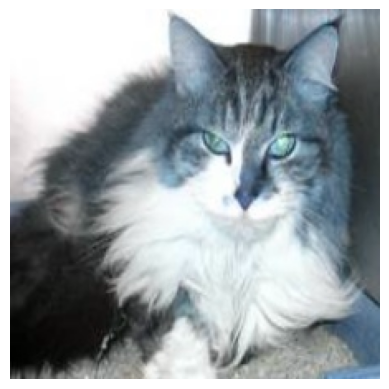

In [ ]:
root_dir = '/content/val_1000'
for img in X:
    pred = model.predict(np.expand_dims(img,0))#.flatten()
    prd_class = decode_prediction(pred)
    print(prd_class[0])

    stripe_cav = cavs[0]
    sign_dir_der, directional_derivative = get_directional_derivatives(img,  model, layer_name, stripe_cav)

    print('predicted class: ', prd_class[0][0])
    print('presence of concept stripe in sample: ', sign_dir_der)
    print('directional_derivative: ', directional_derivative)
    plt.imshow(img[:,:])
    plt.axis('off')
    plt.show()
    break



(224, 224, 3)
1/1 [==============================] - 0s 104ms/step
[[0.90496147]]


Text(0.5, 1.0, 'Dog 0.90496147')

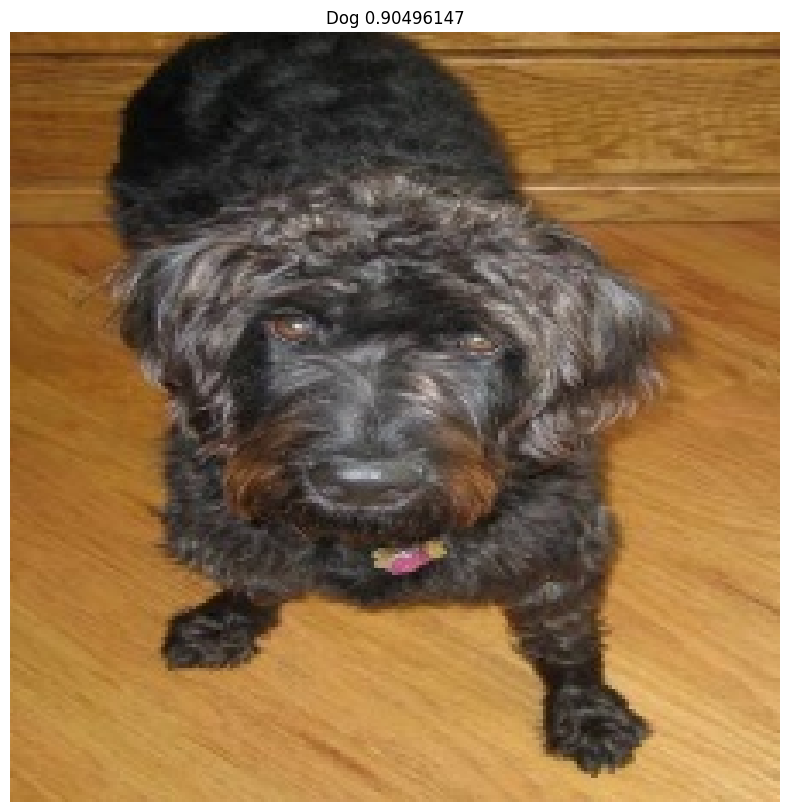

In [ ]:
img = X[59]
label = y[59]
path = files[59]
print(img.shape)
score = model.predict(np.expand_dims(img, axis=0))
print(score)
pred_raw = score[0][0]
pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(pred_label + ' ' + str(pred_raw))

In [ ]:
concept_lst = ['zigzagged', 'dotted', 'striped']
layers = activation_layers[20:]
root_dir = '/content/drive/MyDrive/concepts'
for concept in concept_lst:
  concept_path = os.path.join(root_dir, concept)
  print(concept_path)
  concept_activation, concept_labels = get_activation(concept_path)
  break



/content/drive/MyDrive/concepts/zigzagged


FileNotFoundError: No such file: '/content/random500_0/zigzagged_0089.jpg'

In [ ]:
### concept activations for every concept
def get_concept_activation(folder_path):
  concept_act_s = []
  concept_lbl_s = []

  for file in listdir(folder_path):
    img_path = folder_path+ '/' +file
    img = skimage.io.imread(img_path)
    img = img_preprocess(img)
    activation = np.squeeze(get_layer_activation([np.expand_dims(img,0)])[0])

    concept_act_s.append(activation.flatten())
    concept_lbl_s.append(0)
  return concept_act_s,concept_lbl_s

In [ ]:
## find the directional derivative for every class
def get_conceptual_sensitivity(data, cav_vector, model, layer_name):
  gradient = {}
  for img in data:
      pred = model.predict(np.expand_dims(img,0))[0][0]#.flatten()
      pred_class = decode_prediction(pred)
      if pred_class not in gradient:
        gradient['pred_class'] = []

      sign_dir_der, directional_derivative = get_directional_derivatives(img,  model, layer_name, cav_vector)
      gradient['pred_class'].append(sign_dir_der)
      return gradient


In [ ]:
## find tcav score
def get_tcav_scores(gradients):
  tcav_score = {}
  for label, derivatives in gradients.items():
    tcav_score = np.sum(derivatives)/len(derivatives)
    tcav_score[label] = tcav_score
  return tcav_score


In [ ]:
#imports
import matplotlib.pyplot as plt
import numpy as np


def preprocess_dictionary(input_dictionary):
    """
        Preprocess the input dictionary so it can be plotted
        Args:
            input_dictionary (dict): input dictionary of {concept:{layer:{class: tcav value}}}

        Returns:
            plot_dict (dict) : output dictionary of {class:{layer:[tcav values]}}, tcav values ordered by input concepts
            labels (list): List of concept names
        """
    labels = []
    plot_dict = {}

    for concept, concept_values in input_dictionary.items():
        labels.append(concept)
        for layer, layer_values in concept_values.items():
            for classes, classes_score in layer_values.items():

                if classes not in plot_dict.keys():
                    plot_dict[classes] = {layer: [round(classes_score, 2)]}

                elif layer not in plot_dict[classes].keys():
                    plot_dict[classes][layer] = [round(classes_score, 2)]

                else:
                     plot_dict[classes][layer].append(round(classes_score, 2))
    return plot_dict, labels

def plot_class_tcav_scores(class_dict, labels, class_name):
    """
        Plot the input class dictionary, save at result_plots folder
        Args:
            class_dict (dict): input dictionary of {layer:[tcav values]}, tcav values ordered the same as is labels ordering
            labels (list): List of concept names
            class_name (str): class name

    """

    layer_1_list = class_dict["layer1"]
    layer_2_list = class_dict["layer2"]
    layer_3_list = class_dict["layer3"]
    layer_4_list = class_dict["layer4"]
    layer_5_list = class_dict["layer5"]
    layer_6_list = class_dict["layer6"]

    x = np.arange(len(labels))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width*2.5, layer_1_list, width, label='layer1')
    rects2 = ax.bar(x - width*1.25, layer_2_list, width, label='layer2')
    rects3 = ax.bar(x, layer_3_list, width, label='layer3')
    rects4 = ax.bar(x + width*1.25, layer_4_list, width, label='layer4')
    rects5 = ax.bar(x + width*2.5, layer_5_list, width, label='layer5')
    rects6 = ax.bar(x + width*3.75, layer_6_list, width, label='layer5')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'Tcav scores for the class {class_name}')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects5, padding=3)
    ax.bar_label(rects6, padding=3)

    fig.tight_layout()
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0))
    fig.savefig(f"result_plots\\tcav_scores_{class_name}", bbox_inches='tight', pad_inches=0.5)
    plt.close()


def make_plots(tcav_dict):
    """
    Main plotting function that creates plots to compare the tcav scores accross concepts and layers for each class
    Args:
        input_dictionary (dict): input dictionary of {concept:{layer:{class: tcav value}}}

    """
    plot_dict, labels = preprocess_dictionary(tcav_dict)
    for class_name, class_dict in plot_dict.items():
        plot_class_tcav_scores(class_dict, labels, class_name)



In [ ]:
# Imports
from itertools import combinations
import numpy as np
import seaborn as sns; sns.set_theme()

def Similarity_analysis_plot(concept_cav_vectors, layer_names):
    """
    Main plotting function that creates a similarity heatmap from cav vectors accross layers for concepts
    Args:
        concept_cav_vectors (dict): Input dictionary of cav vectors, where
              key: concept_name, value: dict {layer_name : cav_vector}
        layer_names (list): List of layer names
    """
    # parse and obtain necessary values
    cav_vectors = list(concept_cav_vectors.values())
    concepts = list(concept_cav_vectors.keys())
    number_of_layers = len(cav_vectors[0])
    number_of_concepts =  len(concepts)
    combinations_list = [x for x in range(number_of_concepts)]
    all_combinations_list = list(combinations(combinations_list, 2))

    similarity_list = []
    concept_combinations = []
    for layer_index in range(number_of_layers): # loop through layers
        layer_similarity_list = []
        layer_name = layer_names[layer_index]

        for combination in all_combinations_list: # Loop through all combinations of concepts
            first_concept = concepts[combination[0]]
            second_concept = concepts[combination[1]]
            if len(concept_combinations) != len(all_combinations_list): # If concept label is not in the list, append
                concept_combinations.append(f"{first_concept} and {second_concept}")

            # get similarity scores
            concept_1_cav = concept_cav_vectors[first_concept][layer_name].flatten()
            concept_2_cav = concept_cav_vectors[second_concept][layer_name].flatten()
            similarity = np.dot(concept_1_cav,concept_2_cav)
            layer_similarity_list.append(similarity)
        similarity_list.append(layer_similarity_list)

    ax = sns.heatmap(similarity_list, xticklabels = concept_combinations, yticklabels=layer_names)
    ax.set_title(f'Similarity scores for cav vectors accross layers')
    fig = ax.get_figure()
    fig.savefig("result_plots\\Similarity_scores.png",bbox_inches='tight', pad_inches=0.5)


In [ ]:
concept_lst = ['zigzagged', 'dotted', 'striped']
random_lst = ['random500_0', 'random500_1', 'random500_3']
layers = activation_layers[20:]
root_dir = '/content/drive/MyDrive/concepts'
tcav_scores = {}
for concept in concept_lst:
  concept_path = os.path.join(root_dir, concept)
  #concept_activations, concept_labels = get_concept(concept_path)
  cav_vectors = {}
  for layer in layers:
    lay_idx = model.layers.index(model.get_layer(layer))
    get_layer_activation = K.function([model.input], [model.layers[lay_idx].output])
    concept_activations, concept_labels = get_concept_activation(concept_path)
    cav_vector = get_cav(concept_activations, random_activations, concept_labels, random_labels, clf_type='logistic')
    cav_vectors[layer] = cav_vector
    break
  for layer in layers:
    cav_vector = cav_vectors[layer]
    gradients = get_conceptual_sensitivity(X, cav_vector, model, layer)
    tcav_scores_layer = get_tcav_scores(gradients)
    tcav_scores[concept][layer] = tcav_scores_layer
    break
  break
##plot tcav score for every class##
print(tcav_scores)
make_plots(tcav_scores)
Similarity_analysis_plot(cav_vectors, layers)


X train size:  (66, 75264)
y train size:  (66,)
X valid size:  (22, 75264)
y valid size:  (22,)
Training score:  1.0
Validation score:  0.6818181818181818
1/1 [==============================] - 0s 66ms/step
(1,)
(75264,) 1


ValueError: shapes (75264,) and (1,75264) not aligned: 75264 (dim 0) != 1 (dim 0)